In [1]:
import pandas as pd 
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate #base 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report, roc_auc_score, log_loss, roc_curve, auc
import glob,os,random
import mlflow
from mlflow.models import infer_signature
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_recent_c_df(Carpeta_path: str, sheet_name: str):
    """ Devuelve el df de la hoja especifica, del archivo mas reciente creado de la carpeta especificada"""
    Path_n= Carpeta_path + '/*'
    tipo_de_archivo = '*.xlsx'
    # Busca el archivo más reciente
    archivos = glob.glob(Path_n + tipo_de_archivo)
    archivo_mas_reciente = max(archivos, key=os.path.getctime)
    nombre_del_archivo_N = os.path.basename(archivo_mas_reciente)
    print(archivo_mas_reciente)
    # Lee el archivo sin especificar el tipo de datos
    df = pd.read_excel(archivo_mas_reciente , sheet_name=sheet_name)
    # Si la columna "COMENTARIO" existe, cambia su tipo de datos a str
    if 'COMENTARIO' in df.columns:
        df['COMENTARIO'] = df['COMENTARIO'].astype(str)
    return df,nombre_del_archivo_N

# Proceso:
--------------------------------
   1. Cargo data 
   2. Analisis exploratorio
   3. Balancer Datos
   4. Aplicar encoder para las columnas categoricas
   7. Dividar en train y test y Entrenar modelo
   8. Dummy Clasifier 
   10. Iniciar MLFlow para capturar metricas
   14. Prueba con data Real
   15. Serializacion del Modelo

### 1. Cargo la Data 

In [3]:

dataB,_ = get_recent_c_df(r'C:\Users\C26764\America Movil Peru S.A.C\EAS - 1','Sheet1')
analistas_map = {'JENNY PIZAN':'JENNY',
                 'DANNER YARLEQUE':'DANNER',
                 'LAURA RAFAEL':'LAURA'}
### Normalizo columna Tarjet 
dataB.loc[:,'RESPONSABLE_DE_EA'] = dataB.loc[:,'RESPONSABLE_DE_EA'].str.upper()
dataB.loc[:,'RESPONSABLE_DE_EA'] = dataB.loc[:,'RESPONSABLE_DE_EA'].replace(analistas_map)
dataB.RESPONSABLE_DE_EA.replace(pd.NA,'POR ASIGNAR',inplace=True)

C:\Users\C26764\America Movil Peru S.A.C\EAS - 1\EAUPDATE27.08.xlsx


In [4]:
data4Train = dataB[dataB.RESPONSABLE_DE_EA != 'POR ASIGNAR']
data4Test = dataB[dataB.RESPONSABLE_DE_EA == 'POR ASIGNAR']

data4Test = data4Test[['TEXTO','PROVEEDOR','NOMBRE PROYECTO','TIPO_PROYECTOS','CLASIF_FINANZAS','CLASIF_RED_1','CLASIF_RED_2']]

data4Train = data4Train[['TEXTO','PROVEEDOR','NOMBRE PROYECTO','TIPO_PROYECTOS','CLASIF_FINANZAS',
                                                'CLASIF_RED_1','CLASIF_RED_2','RESPONSABLE_DE_EA']]
for column in data4Train.columns:
    data4Train[column] = data4Train[column].astype('category')

### 2. Analisis Exploratorio

In [5]:
data4Train.describe()

,TEXTO,PROVEEDOR,NOMBRE PROYECTO,TIPO_PROYECTOS,CLASIF_FINANZAS,CLASIF_RED_1,CLASIF_RED_2,RESPONSABLE_DE_EA
count,991,991,991,991,991,991,991,991
unique,36,24,18,17,10,17,7,8
top,MEDICION DE RADIACIONES NO IONIZANTES,SGA TELECOMUNICACIONES S.A.C.,Ampliaciones de Capacidad,ANTENAS,"Radio Bases (Sitios nuevos, ampliacion capacidad)",Ampliación de Capacidad Radio,Radio,ANGGIE
freq,334,334,512,389,871,512,855,507


In [6]:
dataB.RESPONSABLE_DE_EA.value_counts(dropna=False)

RESPONSABLE_DE_EA
ANGGIE      507
JHORDAN     173
DEMETRIO    165
JORGE        50
JENNY        36
DANNER       31
LAURA        18
FERNANDO     11
Name: count, dtype: int64

### 3. Balanceo los datos

In [7]:
# Suponemos que 'df' es tu DataFrame y que 'RESPONSABLE EA' es la columna objetivo
class_counts = data4Train['RESPONSABLE_DE_EA'].value_counts()

# Calculamos la media de muestras por clase
mean_samples = int(class_counts.mean())

# Creamos un DataFrame vacío para almacenar los datos balanceados
df_balanced = pd.DataFrame()

# Iteramos sobre cada clase
for class_name in class_counts.index:
    # Seleccionamos todas las muestras de la clase actual
    df_class = data4Train[data4Train['RESPONSABLE_DE_EA'] == class_name]
    
    # Si el número de muestras en la clase actual es mayor que la media
    if class_counts[class_name] > mean_samples:
        # Realizamos un downsampling: eliminamos aleatoriamente muestras de la clase actual hasta que su número de muestras sea igual a la media
        df_class_balanced = resample(df_class, 
                                     replace=False,  # No permitimos muestrear la misma muestra más de una vez
                                     n_samples=mean_samples,  # El número de muestras a extraer
                                     random_state=123)  # La semilla para el generador de números aleatorios
    else:
        # Si el número de muestras en la clase actual es menor que la media
        # Realizamos un upsampling: añadimos aleatoriamente muestras de la clase actual hasta que su número de muestras sea igual a la media
        df_class_balanced = resample(df_class, 
                                     replace=True,  # Permitimos muestrear la misma muestra más de una vez
                                     n_samples=mean_samples,  # El número de muestras a extraer
                                     random_state=123)  # La semilla para el generador de números aleatorios
    
    # Añadimos la clase balanceada al DataFrame balanceado
    df_balanced = pd.concat([df_balanced, df_class_balanced])
# Imprimimos el número de muestras por clase en el DataFrame balanceado
display(df_balanced['RESPONSABLE_DE_EA'].value_counts())
print("Clases balanceadas")

RESPONSABLE_DE_EA
ANGGIE      123
DANNER      123
DEMETRIO    123
FERNANDO    123
JENNY       123
JHORDAN     123
JORGE       123
LAURA       123
Name: count, dtype: int64

Clases balanceadas


In [8]:
df_balanced.describe()
df_balanced.drop(columns=['CLASIF_RED_2','CLASIF_FINANZAS'],inplace=True)
### Decido dropear 2 columnas que solo introducen ruido al modelo, porque muy alta freq

### 4. Categorizo cada columna (one hot encoder)

In [27]:
df_balanced

,TEXTO,PROVEEDOR,NOMBRE PROYECTO,TIPO_PROYECTOS,CLASIF_RED_1,RESPONSABLE_DE_EA
816,MEDICION DE RADIACIONES NO IONIZANTES,SGA TELECOMUNICACIONES S.A.C.,Ampliaciones de Capacidad,ANTENAS,Ampliación de Capacidad Radio,ANGGIE
676,MEDICION DE RADIACIONES NO IONIZANTES,SGA TELECOMUNICACIONES S.A.C.,Ampliaciones de Capacidad,ANTENAS,Ampliación de Capacidad Radio,ANGGIE
407,IMPLEMENTACIÓN DE ENODO B LTE,SEMI PERU MONTAJES INDUSTRIALES S.A.C.,Ampliaciones de Capacidad,BASEBANDS,Ampliación de Capacidad Radio,ANGGIE
765,MEDICION DE RADIACIONES NO IONIZANTES,SGA TELECOMUNICACIONES S.A.C.,Ampliaciones de Capacidad,RADIOS,Ampliación de Capacidad Radio,ANGGIE
700,MEDICION DE RADIACIONES NO IONIZANTES,SGA TELECOMUNICACIONES S.A.C.,Ampliaciones de Capacidad,ANTENAS,Ampliación de Capacidad Radio,ANGGIE
...,...,...,...,...,...,...
964,DISENO DE PROYECTOS,GERCON S.A.C.,CACs,CACS,CACs (Nuevos y mejoras),FERNANDO
899,DISENO DE PROYECTOS,TNC CONTRATISTAS S.A.C.,Sedes,INMUEBLES,Sedes,FERNANDO
532,ADECUACION OBRA CIVIL SEDE,GERCON S.A.C.,Sedes,INMUEBLES,Sedes,FERNANDO
552,ESCRITORIO DE MELAMINE GRIS,GERCON S.A.C.,Sedes,INMUEBLES,Sedes,FERNANDO


In [9]:
# Crea una copia del DataFrame para no modificar el original
df_encoded = df_balanced.copy()
# Selecciona todas las columnas excepto la columna objetivo
columns_to_encode = df_balanced.columns[df_balanced.columns != 'RESPONSABLE_DE_EA']
# Crea el codificador OneHot
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Aplica el codificador a las columnas seleccionadas
encoded_data = encoder.fit_transform(df_balanced[columns_to_encode])

# Convierte el resultado en un DataFrame y utiliza get_feature_names_out para obtener los nombres de las columnas
df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

# Asegúrate de mantener el índice original
df_encoded.index = df_balanced.index

# Agrega la columna objetivo al DataFrame codificado
#df_encoded = pd.concat([df_encoded, ], axis=1)
df_encoded

,"TEXTO_AA EVAPORADOR 60KBTU 220V/2F R410,COBRE",TEXTO_ADECUACION OBRA CIVIL NODO,TEXTO_ADECUACION OBRA CIVIL SEDE,TEXTO_ADECUACION OBRA CIVIL SITIO TECNICO,TEXTO_AUMENTO DE CARGA ELECTRICA,TEXTO_CAJONERA AEREA,TEXTO_DISENO DE PROYECTOS,TEXTO_ESCRITORIO DE MELAMINE GRIS,TEXTO_EVALUACIÓN ESTRUCTURAL DE TORRE,TEXTO_HABILITACIÓN CAPACIDAD 10GEN LAMBDA 100G,...,CLASIF_RED_1_IP Fotónico,CLASIF_RED_1_Migraciones a FO Urbana,CLASIF_RED_1_Modernización MW Ultima Milla,CLASIF_RED_1_Red de Fibra Óptica Nacional,CLASIF_RED_1_Rollout Sitios Nuevos Macro,CLASIF_RED_1_Rollout Sitios Nuevos Macro - Reubicaciones,CLASIF_RED_1_Sedes,CLASIF_RED_1_Sitios 5G,CLASIF_RED_1_Sitios Nuevos Comerciales,CLASIF_RED_1_Street Cell
816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
899,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
532,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
# Esto solo se hace una vez para crear el experimento de MLFlow 


### 5. Divido en set de pruebas y entrenamiento & entreno el modelo

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded
                                                    , df_balanced['RESPONSABLE_DE_EA'], test_size=0.2, random_state=42)

In [12]:
mlflow.set_experiment("MLflow Quickstart") #Defino el experimento en MLFLOW

<Experiment: artifact_location='file:///D:/Scripts1/sklrn/mlruns/762750926988870532', creation_time=1723061274626, experiment_id='762750926988870532', last_update_time=1723061274626, lifecycle_stage='active', name='MLflow Quickstart', tags={}>

#### Radom Forest

In [24]:
X_test

,"TEXTO_AA EVAPORADOR 60KBTU 220V/2F R410,COBRE",TEXTO_ADECUACION OBRA CIVIL NODO,TEXTO_ADECUACION OBRA CIVIL SEDE,TEXTO_ADECUACION OBRA CIVIL SITIO TECNICO,TEXTO_AUMENTO DE CARGA ELECTRICA,TEXTO_CAJONERA AEREA,TEXTO_DISENO DE PROYECTOS,TEXTO_ESCRITORIO DE MELAMINE GRIS,TEXTO_EVALUACIÓN ESTRUCTURAL DE TORRE,TEXTO_HABILITACIÓN CAPACIDAD 10GEN LAMBDA 100G,...,CLASIF_RED_1_IP Fotónico,CLASIF_RED_1_Migraciones a FO Urbana,CLASIF_RED_1_Modernización MW Ultima Milla,CLASIF_RED_1_Red de Fibra Óptica Nacional,CLASIF_RED_1_Rollout Sitios Nuevos Macro,CLASIF_RED_1_Rollout Sitios Nuevos Macro - Reubicaciones,CLASIF_RED_1_Sedes,CLASIF_RED_1_Sitios 5G,CLASIF_RED_1_Sitios Nuevos Comerciales,CLASIF_RED_1_Street Cell
384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
959,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
478,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Definir los parámetros del Random Forest
params = {
    'ccp_alpha': 0.01,
    'n_estimators': 100,  # Número de árboles en el bosque
    'criterion': 'gini',
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'min_weight_fraction_leaf': 0.0,
    'max_features':'sqrt',
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'bootstrap': True,  # Utilizar muestreo con reemplazo
    'oob_score': False,  # No calcular la puntuación fuera de bolsa
    'n_jobs': -1,  # Utilizar todos los núcleos disponibles
    'random_state': 5,
    'class_weight': 'balanced'
}

# Crear el modelo de Random Forest con los parámetros ajustados
model = RandomForestClassifier(**params)

# Selección de características
selector = SelectFromModel(model)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Realizar la validación cruzada
cv_scores = cross_val_score(model, X_train_selected, y_train, cv=10, scoring='accuracy')

# Imprimir los resultados de la validación cruzada
print("Precisión media de la validación cruzada:", cv_scores.mean())
print("Desviación estándar de la validación cruzada:", cv_scores.std())

# Entrenar el modelo en todo el conjunto de entrenamiento
model.fit(X_train_selected, y_train)

# Evaluar el modelo en el conjunto de prueba
accuracy = model.score(X_test_selected, y_test)
print("Precisión del modelo de Random Forest en el conjunto de prueba:", accuracy)

Precisión media de la validación cruzada: 0.9466407010710809
Desviación estándar de la validación cruzada: 0.017789394134419573
Precisión del modelo de Random Forest en el conjunto de prueba: 0.9593908629441624


In [26]:
X_train

,"TEXTO_AA EVAPORADOR 60KBTU 220V/2F R410,COBRE",TEXTO_ADECUACION OBRA CIVIL NODO,TEXTO_ADECUACION OBRA CIVIL SEDE,TEXTO_ADECUACION OBRA CIVIL SITIO TECNICO,TEXTO_AUMENTO DE CARGA ELECTRICA,TEXTO_CAJONERA AEREA,TEXTO_DISENO DE PROYECTOS,TEXTO_ESCRITORIO DE MELAMINE GRIS,TEXTO_EVALUACIÓN ESTRUCTURAL DE TORRE,TEXTO_HABILITACIÓN CAPACIDAD 10GEN LAMBDA 100G,...,CLASIF_RED_1_IP Fotónico,CLASIF_RED_1_Migraciones a FO Urbana,CLASIF_RED_1_Modernización MW Ultima Milla,CLASIF_RED_1_Red de Fibra Óptica Nacional,CLASIF_RED_1_Rollout Sitios Nuevos Macro,CLASIF_RED_1_Rollout Sitios Nuevos Macro - Reubicaciones,CLASIF_RED_1_Sedes,CLASIF_RED_1_Sitios 5G,CLASIF_RED_1_Sitios Nuevos Comerciales,CLASIF_RED_1_Street Cell
990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
model.feature_importances_

array([0.08169762, 0.02740108, 0.00296523, 0.03999266, 0.00831854,
       0.01285805, 0.00922309, 0.01044361, 0.02270512, 0.0564407 ,
       0.03993736, 0.0688359 , 0.02709186, 0.01245361, 0.07451062,
       0.03240876, 0.02936131, 0.017095  , 0.05149656, 0.01063824,
       0.11979982, 0.05063627, 0.02607106, 0.06592998, 0.0332478 ,
       0.06844017])

In [31]:
model

RandomForestClassifier(ccp_alpha=0.01, class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10, n_jobs=-1,
                       random_state=5)

#### DecisionTreeClassifier

In [27]:
# Define los hiperparámetros// Es el mejor mas rapido, comprobado por interacion
params = {
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 0.01,
    'max_features': 1.0,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 0.00029163021289005544,
    'min_samples_split': 0.0005832604257801109,
    'min_weight_fraction_leaf': 0.0,
    'random_state': 5,
    'splitter': 'best'
}

# Crea el clasificador
clf = DecisionTreeClassifier(**params)
# Realizamos validación cruzada en el conjunto de entrenamiento
scores = cross_val_score(clf, X_train, y_train, cv=10)

print(f'La precisión del modelo en los datos de entrenamiento con validación cruzada es: {scores.mean()}')

# Ajustamos el modelo en el conjunto de entrenamiento
with mlflow.start_run():
    #mlflow.autolog() ## Activo el autolog(aumenta el tiempo de ejecucion)
    clf.fit(X_train, y_train)
    mlflow.log_param("estimator", "DecisionTreeClasifier")
    #mlflow.sklearn.log_model(clf, "model")
# Ahora puedes usar 'clf.predict(X_test)' para predecir los responsables de los proyectos en tu conjunto de prueba
# Calculamos la precisión del modelo en los datos de prueba
precision = clf.score(X_test, y_test)

print(f'La precisión del modelo en los datos de prueba es: {precision}')
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


La precisión del modelo en los datos de entrenamiento con validación cruzada es: 0.9949358974358974
La precisión del modelo en los datos de prueba es: 1.0


### 5.5 Dummy Clasifier 

In [14]:
modelo = DummyClassifier()
results = cross_validate(modelo, X_test, y_test, cv = 5, return_train_score=False)
media = results['test_score'].mean()
desviacion_estandar = results['test_score'].std()
print("Accuracy con dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desviacion_estandar)*100, (media + 2 * desviacion_estandar) * 100))

2024/09/05 15:19:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '517514dd6cd34bacbb974b6d912a1996', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024/09/05 15:19:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fc1d4b92f7ff409d8f0dd84ed7c29c71', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precis

Accuracy con dummy stratified, 10 = [15.34, 19.17]


### 5.6 Metricas interesantes 

In [53]:
clf = model

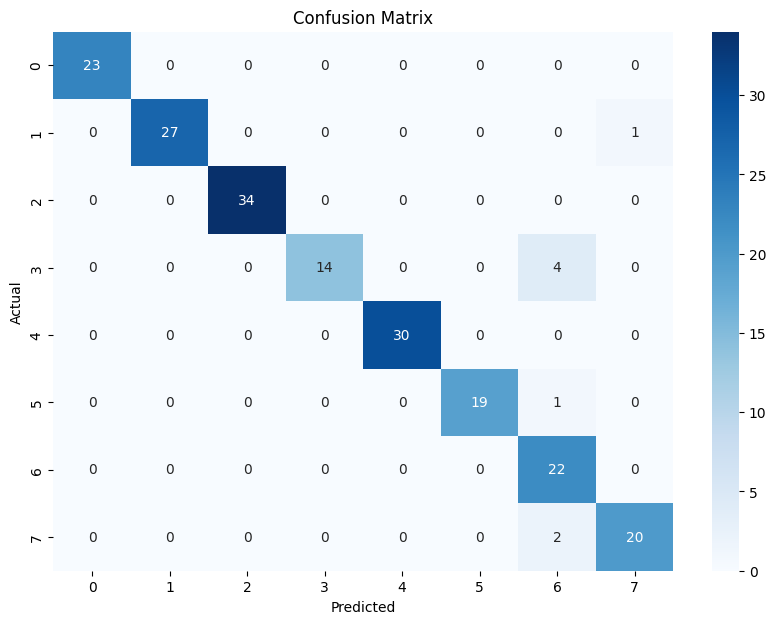

In [59]:
# Predicciones del modelo
y_pred = clf.predict(X_test_selected)

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

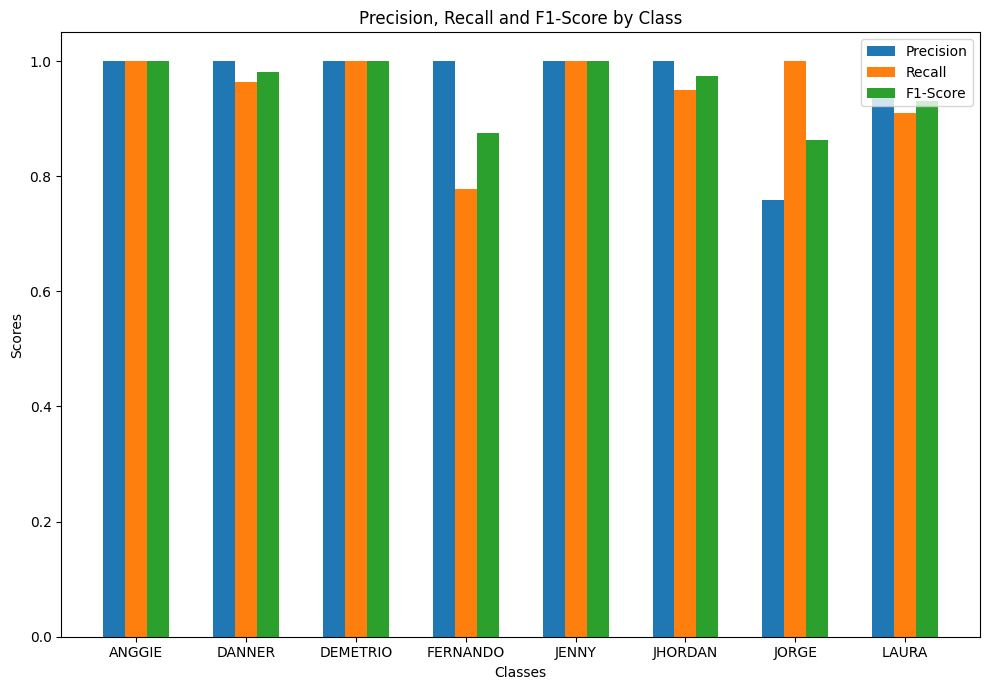

ROC AUC Score: 0.9972618630028558


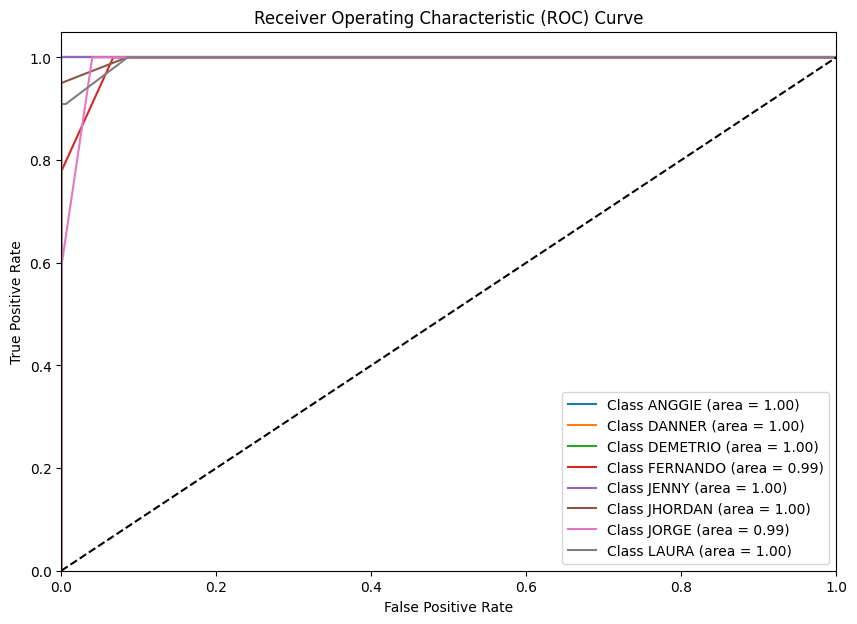

Log Loss: 0.1579500836922583


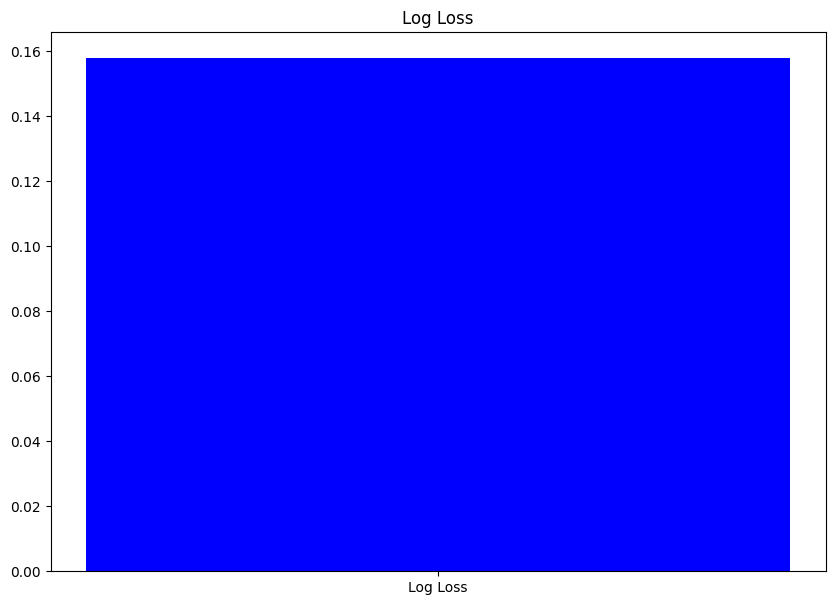

In [60]:
# Generar el reporte de clasificación con zero_division=1
report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
# Predicciones del modelo
y_pred = clf.predict(X_test_selected)
y_prob = clf.predict_proba(X_test_selected) 
# Obtener las clases únicas de y_test
classes = np.unique(y_test)

# Extraer precision, recall y f1-score para cada clase
precision = [report[str(cls)]['precision'] for cls in classes]
recall = [report[str(cls)]['recall'] for cls in classes]
f1_score = [report[str(cls)]['f1-score'] for cls in classes]

# Crear gráfico de barras para precision, recall y f1-score
x = np.arange(len(precision))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall and F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

fig.tight_layout()
plt.show()

# Calcular y mostrar ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f'ROC AUC Score: {roc_auc}')

# Crear curvas ROC para cada clase
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=classes[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 7))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calcular y mostrar Log Loss
logloss = log_loss(y_test, y_prob)
print(f'Log Loss: {logloss}')

# Crear gráfico de Log Loss
plt.figure(figsize=(10, 7))
plt.bar(['Log Loss'], [logloss], color='blue')
plt.title('Log Loss')
plt.show()

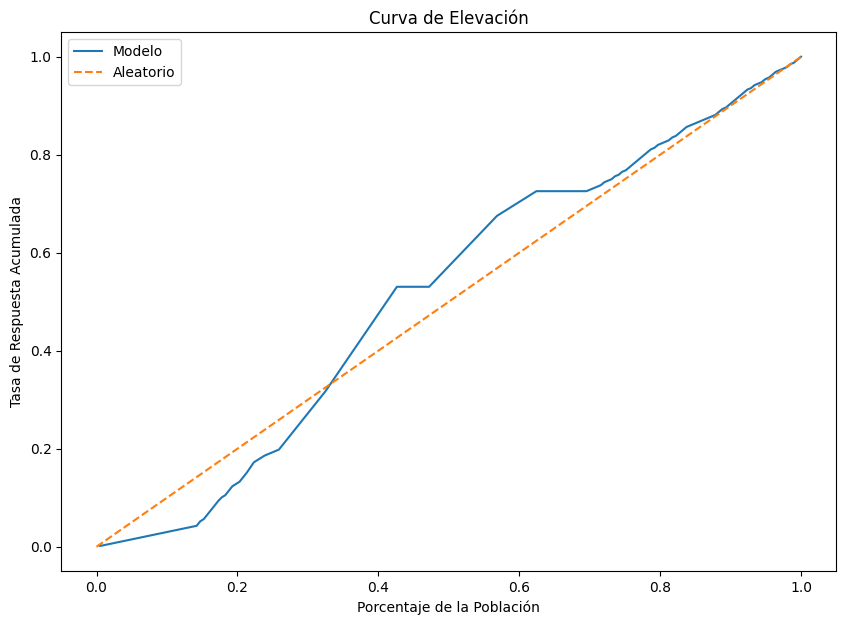

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve

# Convertir y_test a valores numéricos si es necesario
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Predicciones del modelo
y_prob = clf.predict_proba(X_test_selected)[:, 1]  # Probabilidades de la clase positiva

# Ordenar las instancias por probabilidad
sorted_indices = np.argsort(y_prob)[::-1]
y_test_sorted = y_test_encoded[sorted_indices]
y_prob_sorted = y_prob[sorted_indices]

# Calcular la tasa de respuesta acumulada
cumulative_gains = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)
percentiles = np.arange(1, len(y_test_sorted) + 1) / len(y_test_sorted)

# Graficar la curva de elevación
plt.figure(figsize=(10, 7))
plt.plot(percentiles, cumulative_gains, label='Modelo')
plt.plot([0, 1], [0, 1], linestyle='--', label='Aleatorio')
plt.xlabel('Porcentaje de la Población')
plt.ylabel('Tasa de Respuesta Acumulada')
plt.title('Curva de Elevación')
plt.legend()
plt.show()



### 6. Guardo la data en el MLFlow

#### Registro el model en el MLFlow ( De forma manueal, inecesario is ya active el autolog) 

In [18]:
# Start an MLflow run
with mlflow.start_run() as run:
     # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
     # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic DesicionTree model for analist data")
    # Infer the model signature
    signature = infer_signature(X_train, clf.predict(X_train))
    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=clf,
        artifact_path="DecisionTreeModel",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-Responsables",
    )

Registered model 'tracking-Responsables' already exists. Creating a new version of this model...
Created version '5' of model 'tracking-Responsables'.


### 7. Pruebas reales 

#### Hago prueba con las filas random


In [289]:
random.seed(15)
lista = random.sample(range(1, 1257), 15)
df_test = dataB.loc[lista]
df_test['RESPONSABLE_DE_EA'].tolist()

['ANGGIE',
 'ANGGIE',
 'ANGGIE',
 'ANGGIE',
 'JHORDAN',
 'ANGGIE',
 'DEMETRIO',
 'ANGGIE',
 'ANGGIE',
 'DEMETRIO',
 'DEMETRIO',
 'ANGGIE',
 'ANGGIE',
 'ANGGIE',
 'JENNY']

In [292]:
data2test = df_test[['TEXTO','PROVEEDOR','NOMBRE PROYECTO','TIPO_PROYECTOS','CLASIF_RED_1']].copy()

In [293]:
df_real = data2test.copy()

#### Normalizo la entrada de que tenga el formato del modelo, igualo columnas

In [319]:
def process_2_model(df_real:pd.DataFrame):
        # Supongamos que 'encoder' es tu OneHotEncoder ya ajustado y 'df_real' es tu DataFrame real
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_data = encoder.fit_transform(df_real)
    
    # Aplica el codificador a tus datos reales
    df_real_encoded = encoder.transform(df_real)
    
    # Convierte el resultado en un DataFrame
    df_real_encoded = pd.DataFrame(df_real_encoded, columns=encoder.get_feature_names_out(df_real.columns))
    
    # Asegúrate de que todas las columnas en tus datos de entrenamiento también existen en tus datos reales
    for col in df_encoded.columns:
        if col not in df_real_encoded.columns:
            # Si falta alguna columna en tus datos reales, añade una nueva columna llena de ceros
            df_real_encoded[col] = 0
    # Ordena las columnas de df_real_encoded para que coincidan con el orden de las columnas en df_encoded
    df_real_encoded = df_real_encoded.reindex(columns=df_encoded.columns)
    return df_real_encoded


    
    

In [295]:
df_real_encoded = df_real_encoded.drop(columns=['RESPONSABLE_DE_EA'])

In [297]:
list_predic = clf.predict(df_real_encoded).tolist()

In [298]:
list_predic

['LAURA',
 'LAURA',
 'LAURA',
 'LAURA',
 'LAURA',
 'LAURA',
 'DEMETRIO',
 'LAURA',
 'LAURA',
 'DEMETRIO',
 'DEMETRIO',
 'LAURA',
 'LAURA',
 'LAURA',
 'JENNY']

### 8. Serializo el modelo para guardarlo

In [ ]:
with open(r'\\LIMBIPBICOV01.claro.pe\Red Región Norte\EAS\model_v1.pkl', 'wb') as f:
    # Usar pickle.dump para serializar y guardar el objeto
    pickle.dump(clf, f)  

In [ ]:
with open(r'\\LIMBIPBICOV01.claro.pe\Red Región Norte\EAS\model_v2.pkl', 'wb') as f:
    # Usar pickle.dump para serializar y guardar el objeto
    pickle.dump(model, f)  